#1-1

MNIST 데이터셋을 사용하여 간단한 GAN을 구현한 코드입니다.

코드를 실행시키고, 주석을 달아주세요.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image


In [ ]:
# 학습할 에폭 수
num_epochs = 100

# 한 번에 처리할 데이터 샘플(batch)의 크기
batch_size = 100

# 옵티마이저에서 사용할 학습률
learning_rate = 0.0002

# 입력 이미지 크기 (28x28 픽셀을 1차원 벡터로 변환)
img_size = 28 * 28

# 노이즈 벡터의 크기 (생성 네트워크의 입력 크기)
noise_size = 100

# 첫 번째 은닉층의 크기
hidden_size1 = 256

# 두 번째 은닉층의 크기
hidden_size2 = 512

# 세 번째 은닉층의 크기
hidden_size3 = 1024

# 결과를 저장할 디렉터리 이름 (생성된 이미지나 모델 저장)
dir_name = "GAN_results"

# CUDA를 사용할 수 있으면 GPU를, 그렇지 않으면 CPU를 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 결과 디렉터리가 존재하지 않으면 새로 생성
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# 데이터 전처리를 위한 변환 설정:
# 1. 이미지를 텐서로 변환
# 2. (0.5)를 평균으로, (0.5)를 표준편차로 정규화하여 픽셀 값을 [-1, 1] 범위로 스케일링
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# MNIST 데이터셋을 다운로드 및 로드 (훈련 데이터로 사용)
MNIST_dataset = datasets.MNIST(root='../../data/',  # 데이터셋을 저장할 경로
                               train=True,  # 훈련용 데이터셋 로드
                               transform=transform,  # 전처리 변환 적용
                               download=True)  # 데이터셋이 없으면 다운로드

# DataLoader를 사용하여 배치 크기만큼 데이터를 로드하고 셔플
data_loader = torch.utils.data.DataLoader(dataset=MNIST_dataset,  # 데이터셋 로드
                                          batch_size=batch_size,  # 한 배치에 포함될 데이터 개수
                                          shuffle=True)  # 데이터를 매번 셔플하여 랜덤하게 로드


In [ ]:
# Discriminator 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 순차적인 레이어 구조 정의
        self.model = nn.Sequential(
            # 입력 이미지 크기를 첫 번째 은닉층 크기로 변환
            nn.Linear(img_size, hidden_size3),
            # LeakyReLU 활성화 함수
            nn.LeakyReLU(0.2),
            # 첫 번째 은닉층을 두 번째 은닉층 크기로 변환
            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2),
            # 두 번째 은닉층을 세 번째 은닉층 크기로 변환
            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2),
            # 세 번째 은닉층에서 하나의 스칼라 값 출력
            nn.Linear(hidden_size1, 1),
            # 출력 값을 [0, 1] 범위로 제한하기 위해 Sigmoid 활성화 함수 사용
            nn.Sigmoid()
        )

    # 순전파 함수
    def forward(self, x):
        return self.model(x)


# Generator 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 순차적인 레이어 구조 정의
        self.model = nn.Sequential(
            # 노이즈 크기를 첫 번째 은닉층 크기로 변환
            nn.Linear(noise_size, hidden_size1),
            # ReLU 활성화 함수
            nn.ReLU(),
            # 첫 번째 은닉층을 두 번째 은닉층 크기로 변환
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            # 두 번째 은닉층을 세 번째 은닉층 크기로 변환
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            # 세 번째 은닉층에서 원래 이미지 크기로 출력
            nn.Linear(hidden_size3, img_size),
            # 출력 값을 [-1, 1] 범위로 제한하기 위해 Tanh 활성화 함수 사용
            nn.Tanh()
        )

    # 순전파 함수
    def forward(self, x):
        return self.model(x)

# 판별자와 생성자 모델을 생성하고, 사용 가능한 장치(GPU/CPU)로 이동
discriminator = Discriminator().to(device)
generator = Generator().to(device)

# BCELoss: 이진 교차 엔트로피 손실 함수
criterion = nn.BCELoss()

# Adam 옵티마이저 설정
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)


In [ ]:
# GAN 학습을 위한 에폭 반복
for epoch in range(num_epochs):
    # 배치 단위로 데이터 로드
    for i, (images, _) in enumerate(data_loader):
        # 진짜 이미지에 대한 레이블
        real_labels = torch.ones(batch_size, 1).to(device)
        # 가짜 이미지에 대한 레이블
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 실제 이미지를 배치 크기만큼 1차원 벡터로 변환하고 장치로 이동
        real_images = images.reshape(batch_size, -1).to(device)

        # 생성자의 역전파를 위한 그라디언트 초기화
        g_optimizer.zero_grad()

        # 생성자에 입력할 노이즈 벡터 z 생성
        z = torch.randn(batch_size, noise_size).to(device)
        # 생성자가 노이즈를 입력받아 가짜 이미지를 생성
        fake_images = generator(z)

        # 생성자의 손실 계산
        g_loss = criterion(discriminator(fake_images), real_labels)
        # 생성자의 손실에 대한 역전파 및 파라미터 업데이트
        g_loss.backward()
        g_optimizer.step()

        # 판별자(D)의 역전파를 위한 그라디언트 초기화
        d_optimizer.zero_grad()

        # 새로운 노이즈 벡터 z 생성하여 가짜 이미지 생성
        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        # 진짜 이미지에 대한 판별자의 손실 계산
        real_loss = criterion(discriminator(real_images), real_labels)
        # 가짜 이미지에 대한 판별자의 손실 계산
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        # 판별자의 총 손실 계산
        d_loss = (real_loss + fake_loss) / 2

        # 판별자의 손실에 대한 역전파 및 파라미터 업데이트
        d_loss.backward()
        d_optimizer.step()

        # 150 스텝마다 학습 상태를 출력
        if (i + 1) % 150 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(data_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # 각 에폭마다 가짜 이미지를 저장
    save_image(fake_images.view(batch_size, 1, 28, 28),
               os.path.join(dir_name, f'GAN_fake_image_{epoch + 1}.png'))

    # 판별자와 생성자의 성능 측정
    d_performance = discriminator(real_images).mean().item()
    g_performance = discriminator(fake_images).mean().item()
    print(f"---------Epoch [{epoch + 1}/{num_epochs}] : D Performance: {d_performance:.2f}, G Performance: {g_performance:.2f}")

#1-2

아래 마크다운으로 GAN_fake_image_1.png와 GAN_fake_image_100.png를 함께 첨부해주세요.

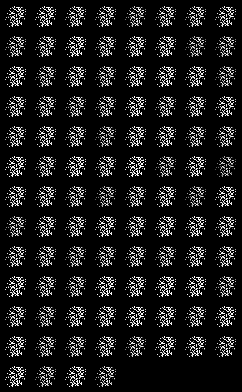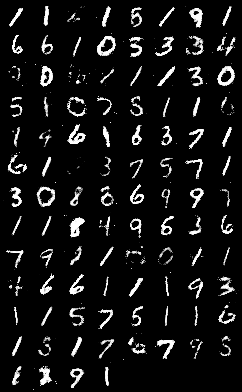